#**UNIVERSITYHACK 2022 DATATHON**:    ***Parte exploratoria:***

## **INTRODUCCIÓN**

En este Datathon se nos ha planteado el reto de la correcta estimación de la demanda de agua potable. 
Nuestro principal objetivo ha sido identificar, aislar y emplear las variaciones temporales, así como otros factores económicos y naturales para lograr de esta forma la mejor predicción. Hemos partido de un amplio dataset con un histórico de consumos de la zona geográfica del litoral valenciano.



Resumen del análisis preliminar con código y explicaciones

# 1. Importación de librerías y del dataset

In [ ]:
import pandas as pd 
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from array import array
from statsmodels.tsa.stattools import adfuller

import warnings 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Datathon_2022/Modelar_UH2022.txt", sep='|')

# 2. Análisis exploratorio 

Nuestro dataset contiene la información sobre el consumo de agua de 2.747 contadores, ubicados en el litoral de la  Comunidad Valenciana, pudiendo comprender viviendas, locales comerciales o industrias.

In [ ]:
df.head(8500) 

NameError: ignored

Las variables son:


      • ID: Identificador del Contador que registra la medida de lectura. 

      • SAMPLETIME: Fecha y hora del consumo en formato UTC.
       Momento en el que se  produce el mensaje o el contador ha emitido el registro. 

      • READINGINTEGER: Medida registrada por el contador en litros. Parte entera. 
      
      • READINGTHOUSANDTH: Medida registrada por el contador en litros. Parte decimal. 

      • DELTAINTEGER: Consumo calculado en litros a partir de la medida registrada por el  contador. Parte entera. 

      • DELTATHOUSANDTH: Consumo calculado en litros a partir de la medida registrada por el  contador. Parte decimal.

In [ ]:
print("Number of rows is = ", df.shape[0], " \nNumber of columns is = " , df.shape[1])   

Number of rows is =  21404828  
Number of columns is =  6


In [ ]:
 df['ID'].unique() 

array([   0,    1,    2, ..., 2748, 2749, 2756])

In [ ]:
df['SAMPLETIME'] = pd.to_datetime(df['SAMPLETIME'], errors='coerce')  

### 2.1 Ver valores de NA 

In [ ]:
pd.Series(df.isnull().sum()).rename_axis('features/target').to_frame('Missing Value Count')

,Missing Value Count
features/target,
ID,0
SAMPLETIME,0
READINGINTEGER,0
READINGTHOUSANDTH,140056
DELTAINTEGER,0
DELTATHOUSANDTH,140056


In [ ]:
pd.Series((df.isnull().sum() / len(df))*100).sort_values(ascending = False).to_frame('Missing Value Percent')

,Missing Value Percent
READINGTHOUSANDTH,0.65432
DELTATHOUSANDTH,0.65432
ID,0.00000
SAMPLETIME,0.00000
READINGINTEGER,0.00000
DELTAINTEGER,0.00000


In [ ]:
df[df['READINGTHOUSANDTH'].isna()]

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
2085142,248,2019-06-13 18:30:00,26752630,NaN,0,NaN
2085143,248,2019-06-13 04:30:00,26676570,NaN,3290,NaN
2085144,248,2019-06-13 16:30:00,26752630,NaN,0,NaN
2085145,248,2019-06-13 18:45:00,26752630,NaN,0,NaN
2085146,248,2019-06-13 09:45:00,26736300,NaN,2780,NaN
...,...,...,...,...,...,...
12101320,1416,2020-01-25 11:00:00,30935150,NaN,250,NaN
12101321,1416,2020-01-25 09:30:00,30933640,NaN,260,NaN
12101322,1416,2020-01-25 16:00:00,30940130,NaN,250,NaN
12101323,1416,2020-01-26 06:00:00,30954430,NaN,270,NaN


In [ ]:
df['READINGTHOUSANDTH'].value_counts()

0.0     18836054
8.0       235047
6.0       217849
4.0       208193
2.0       206955
          ...   
87.0        3462
13.0        3460
75.0        2769
25.0        2762
99.0        1235
Name: READINGTHOUSANDTH, Length: 91, dtype: int64

Parece que hay contadores en los que no se ha grabado el número decimal. Lo sustituimos por cero

In [ ]:
df = df.fillna(0.0)

CONCLUSIÓN DE ESTE PUNTO

Del análisis de los NAs pudimos identificar que un total de 140056 registros no tenían información en la parte decimal de la lectura (por lo tanto, ni para READING ni para DELTA). 
Decidimos imputar los valores NA por ceros, viendo la distribución previa de los ceros en los contadores y que dado que solo se observan en la parte decimal, el margen de error es despreciable.

### 2. 2 CREAMOS LA NUEVA TABLA CON LA SUMA DE PARTE ENTERA Y DECIMAL Y ORDENAMOS POR FECHA 

In [ ]:
df['READING'] = df['READINGINTEGER']+df['READINGTHOUSANDTH']/100

df['DELTA'] = df['DELTAINTEGER']+df['DELTATHOUSANDTH']/100

In [ ]:
df= df.drop(['READINGINTEGER', 'READINGTHOUSANDTH', 'DELTAINTEGER', 'DELTATHOUSANDTH'], axis=1)

df.head()

,ID,SAMPLETIME,READING,DELTA
0,0,2019-06-13 08:34:09,369320.0,17.0
1,0,2019-06-13 17:34:10,369403.0,2.0
2,0,2019-06-13 18:34:10,369403.0,0.0
3,0,2019-06-13 04:34:10,369284.0,1.0
4,0,2019-06-13 14:34:10,369356.0,28.0


Vamos a ordenar la data por fecha para poder trabajar mucho más cómodos. 

In [ ]:
df= df.sort_values(by=['ID',"SAMPLETIME"])

### 2.3 Registros con valores igual a 0

In [ ]:
 registro_0=df[(df['DELTA']==0) & (df['READING']==0)]
 registro_0['ID'].unique()

array([ 272,  323,  461,  549, 1225, 1261, 1506, 1837, 1896, 2001, 2089,
       2135, 2231, 2369, 2542, 2544, 2545, 2547, 2690])

Observamos que estos contadores tiene en algún momento de su vida todos los registros igual a 0, nos interesa saber qué proporción del total de los registros constituye para poder tomar decisiones

In [ ]:
l1=registro_0.groupby('ID').size()
l1

ID
272     8759
323     2088
461       64
549      120
1225      15
1261     127
1506       5
1837     789
1896    8759
2001      42
2089     119
2135    6464
2231      45
2369     120
2542    4983
2544    4982
2545    4982
2547    4909
2690      20
dtype: int64

Ver cuántos registros totales tienen esos contadores

In [ ]:
mask = df['ID'].isin([272,  323,  461,  549, 1225, 1261, 1506, 1837, 1896, 2001, 2089,
       2135, 2231, 2369, 2542, 2544, 2545, 2547, 2690])

df.loc[mask]
l2=df.loc[mask].groupby('ID').size()
l2

ID
272     8759
323     6393
461     6438
549     6444
1225    6490
1261    6392
1506    8629
1837    6391
1896    8759
2001    6153
2089    6926
2135    6464
2231    6493
2369    5917
2542    4983
2544    4982
2545    4982
2547    4909
2690    3827
dtype: int64

Los contadores (272,1896,2135,2542,2544,2545,2547) tienen todos sus registros igual a 0, por lo que lo vamos a proceder a eliminarlos. Se toma esta decisión, tomando como base la teoría de que los contadores citados pueden estar averiados o fuera de uso.

In [ ]:
df = df[~df['ID'].isin([272,1896,2135,2542,2544,2545,2547])]

In [ ]:
len(df)

21360990

Se pierden un total de 43.838 registros, que constituyen tan solo 0.204% del total de los registros.

Para la toma de decisiones respecto al resto de contadores que presentan algún registro igual a cero, se procede a realizar un análisis temporal a fin de detectar comportamientos anómalos. Estos registros iguales a cero pueden deberse a un inicio del consumo de agua posterior a la fecha de alta del contador.

In [ ]:
DF_323=df[(df['ID']==323)]
DF_323.head()     

# Prueba manual para corroborar lo que pensábamos de que los no registros son al principio de la vida del contador.

,ID,SAMPLETIME,READING,DELTA
2779263,323,2019-05-10 15:36:36,0.0,0.0
2778815,323,2019-05-10 16:36:36,0.0,0.0
2779261,323,2019-05-10 17:36:36,0.0,0.0
2779262,323,2019-05-10 18:36:36,0.0,0.0
2779264,323,2019-05-10 19:36:34,0.0,0.0


In [ ]:
# FECHAS EN LAS QUE EMPIEZAN DEJAN DE SER CEROS
df_new=df[(df['READING']!=0)].loc[mask].groupby(['ID']).agg({'SAMPLETIME': [np.min]})
df_new

,SAMPLETIME
,amin
ID,
323,2019-08-05 15:33:04
461,2019-05-11 10:35:50
549,2019-05-13 12:00:00
1225,2019-05-07 05:30:27
1261,2019-05-15 23:11:52
1506,2019-02-01 00:00:00
1837,2019-06-12 14:34:03
2001,2019-05-22 09:50:47


In [ ]:
# PRIMERA FECHA DE REGISTRO

df_new=df.loc[mask].groupby(['ID']).agg({'SAMPLETIME': [np.min]})
df_new

,SAMPLETIME
,amin
ID,
323,2019-05-10 15:36:36
461,2019-05-08 18:35:58
549,2019-05-08 12:06:50
1225,2019-05-06 14:30:31
1261,2019-05-10 16:12:03
1506,2019-02-01 00:00:00
1837,2019-05-10 17:35:37
2001,2019-05-20 15:50:50


CONCLUSIÓN DE ESTE PUNTO

Se ha procedido a eliminar un total de 7 contadores  (272,1896,2135,2542,2544,2545,2547) al tener todos sus registros igual a 0.

Respecto al resto de contadores, se observa que los ragistros igual a cero se corresponden con los primeros días de medida, confirmando nuestra teoría (el inicio de consumo de agua tiene lugar posterior a la fecha de alta del contador).

### 2.3 Análisis de negativos

En primer lugar, se procede a realizar un análisis del número de negativos exitente en la variable READING, la variable DELTA y en ambas variables.

In [ ]:
delta_negativo= df[(df['DELTA']<0)]
delta_negativo

,ID,SAMPLETIME,READING,DELTA
32172,3,2019-05-10 11:44:54,193908.0,-1.0
62351,7,2019-04-25 11:36:10,200781.0,-4.0
62348,7,2019-04-25 12:36:10,200780.0,-1.0
66829,7,2019-04-25 13:36:10,200779.0,-1.0
83620,9,2019-05-24 01:32:09,211841.0,-5.0
...,...,...,...,...
21396527,2711,2019-12-16 10:22:29,-63614.0,-161.0
21396533,2711,2019-12-16 11:22:29,-63736.0,-122.0
21396539,2711,2019-12-16 12:22:29,-63854.0,-118.0
21396538,2711,2019-12-16 13:22:30,-63961.0,-107.0


In [ ]:
len(delta_negativo['ID'].unique())

486

Un total de 486 contadores presentan algún registro con DELTA negativo.

In [ ]:
reading_negativo=df[(df['READING']<0)]
reading_negativo

,ID,SAMPLETIME,READING,DELTA
8892982,1041,2019-02-01 00:44:59,-29505.0,0.0
8892975,1041,2019-02-01 01:44:59,-29505.0,0.0
8892991,1041,2019-02-01 02:00:00,-29505.0,0.0
8892980,1041,2019-02-01 03:00:00,-29505.0,0.0
8892974,1041,2019-02-01 04:00:00,-29505.0,0.0
...,...,...,...,...
21395487,2711,2020-01-31 19:20:51,-12934.0,1.0
21395485,2711,2020-01-31 20:20:51,-12933.0,1.0
21395486,2711,2020-01-31 21:20:54,-12925.0,8.0
21395482,2711,2020-01-31 22:20:54,-12924.0,1.0


In [ ]:
len(reading_negativo['ID'].unique())

2

In [ ]:
reading_negativo['ID'].unique()

array([1041, 2711])

Unicamente dos contadores presentan registros de lectura negativos (el 1041 y el 2711).

In [ ]:
los_dos_negativos=df[(df['DELTA']<0) & (df['READING']<0)]
los_dos_negativos

,ID,SAMPLETIME,READING,DELTA
8899519,1041,2019-12-19 14:29:24,-23199.0,-10.0
8899515,1041,2019-12-19 15:29:24,-23202.0,-3.0
21396079,2711,2019-10-08 15:25:03,-8498.0,-153.0
21396080,2711,2019-10-08 16:25:03,-8592.0,-94.0
21396085,2711,2019-10-08 17:25:03,-8756.0,-164.0
...,...,...,...,...
21396527,2711,2019-12-16 10:22:29,-63614.0,-161.0
21396533,2711,2019-12-16 11:22:29,-63736.0,-122.0
21396539,2711,2019-12-16 12:22:29,-63854.0,-118.0
21396538,2711,2019-12-16 13:22:30,-63961.0,-107.0


In [ ]:
los_dos_negativos['ID'].unique()

array([1041, 2711])

Se detecta, además, que los dos contadores con READING negativo presentan también un DELTA negativo.

Veamos que ocurre con estos dos contadores problematicos (1041, 2711)

#### 2.3.1. ANÁLISIS CONTADOR PROBLEMÁTICO 2711

In [ ]:
DF_2711= df[(df['ID']==2711)]
DF_2711.head(15)

,ID,SAMPLETIME,READING,DELTA
21396086,2711,2019-10-08 14:25:03,-8345.0,0.0
21396079,2711,2019-10-08 15:25:03,-8498.0,-153.0
21396080,2711,2019-10-08 16:25:03,-8592.0,-94.0
21396085,2711,2019-10-08 17:25:03,-8756.0,-164.0
21396083,2711,2019-10-08 18:25:02,-8856.0,-100.0
21396087,2711,2019-10-08 19:25:02,-8878.0,-22.0
21396082,2711,2019-10-08 20:25:02,-8879.0,-1.0
21396084,2711,2019-10-08 21:25:02,-8880.0,-1.0
21396081,2711,2019-10-08 22:25:03,-8880.0,0.0
21395260,2711,2019-10-08 23:25:03,-8880.0,0.0


Se observa que en la mayoría de los casos, a pesar de ser el valor de lectura negativo, el DELTA aumenta en valor absoluto. Veamos si existe algún registro en el que el DELTA sea positivo, lo que indicaría que el DELTA disminuye en términos de valor absoluto.

In [ ]:
DF_2711[DF_2711['DELTA']>0]

,ID,SAMPLETIME,READING,DELTA
21396102,2711,2019-10-09 18:00:00,-9662.96,0.04
21396106,2711,2019-10-09 19:00:00,-9662.92,0.04
21395263,2711,2019-10-09 20:00:00,-9663.98,0.04
21396091,2711,2019-10-09 21:00:00,-9663.94,0.04
21396093,2711,2019-10-09 22:24:57,-9665.00,0.04
...,...,...,...,...
21395481,2711,2020-01-31 17:20:51,-12935.00,2.00
21395487,2711,2020-01-31 19:20:51,-12934.00,1.00
21395485,2711,2020-01-31 20:20:51,-12933.00,1.00
21395486,2711,2020-01-31 21:20:54,-12925.00,8.00


In [ ]:
len(DF_2711)

2770

Se observa que en el contador 2711 no se produce un aumento del DELTA en valor absoluto en 727 registros de lectura, de un total de 2770 registros (lo que se corresponde casi con un tercio de los registros.

#### 2.3.2. ANÁLISIS CONTADOR PROBLEMÁTICO 1041

Realicemos el mismo análisis con el contador 1041.

In [ ]:
DF_1041= df[(df['ID']==1041)]
DF_1041

,ID,SAMPLETIME,READING,DELTA
8892982,1041,2019-02-01 00:44:59,-29505.0,0.0
8892975,1041,2019-02-01 01:44:59,-29505.0,0.0
8892991,1041,2019-02-01 02:00:00,-29505.0,0.0
8892980,1041,2019-02-01 03:00:00,-29505.0,0.0
8892974,1041,2019-02-01 04:00:00,-29505.0,0.0
...,...,...,...,...
8897982,1041,2020-01-31 19:27:32,-22759.0,6.0
8897975,1041,2020-01-31 20:27:32,-22759.0,0.0
8897972,1041,2020-01-31 21:27:32,-22759.0,0.0
8897989,1041,2020-01-31 22:27:34,-22759.0,0.0


In [ ]:
DF_1041[DF_1041['DELTA']>0]

,ID,SAMPLETIME,READING,DELTA
8898295,1041,2019-02-04 20:44:48,-29496.0,9.0
8893038,1041,2019-02-04 21:44:48,-29491.0,5.0
8893063,1041,2019-02-05 14:44:46,-29489.0,2.0
8893055,1041,2019-02-05 17:44:46,-29484.0,5.0
8893066,1041,2019-02-05 18:44:45,-29479.0,5.0
...,...,...,...,...
8897954,1041,2020-01-30 18:27:34,-22781.0,5.0
8897955,1041,2020-01-30 19:27:34,-22775.0,6.0
8897953,1041,2020-01-30 20:27:34,-22770.0,5.0
8897956,1041,2020-01-30 21:27:34,-22765.0,5.0


In [ ]:
DF_1041[DF_1041['DELTA']<0]

,ID,SAMPLETIME,READING,DELTA
8899519,1041,2019-12-19 14:29:24,-23199.0,-10.0
8899515,1041,2019-12-19 15:29:24,-23202.0,-3.0


El contador 1041, además de presentar registros negativos, sigue un comportamiento practicamente constante. Cuando no se mantiene constante, sigue una tendencia decreciente, en el DELTA, en términos de valor absoluto.

#### 2.3.3. DECISIÓN RESPECTO A CONTADORES PROBLEMÁTICOS

Puesto que no se encuentra un razonamiento lógico al comportamiento de estos contadores, se toma la decision de eliminarlos del conjunto de registros.

In [ ]:
df = df[~df['ID'].isin([2711, 1041])]

In [ ]:
len(df)

21349461

Se renuncia a un total de 11.529 registros.

#### 2.3.4. ANÁLISIS CONTADORES CON SOLO DELTA NEGATIVO

Pasamos ahora a la problemática de los que tienen el DELTA negativo en alguno de sus puntos. Se considera que esta problemática se debe a errores en la lectura, por lo que se opta por sustituir dichos DELTAS negativos por cero.

In [ ]:
len(df[df['DELTA']<0])

7743

In [ ]:
len(df[df['DELTA']==0])

10672308

In [ ]:
df['DELTA'] = df['DELTA'].apply(lambda x: 0 if x<0 else x)

Pasamos a comprobar que, efectivamente, los valores negativos de DELTA han sido eliminados. 

In [ ]:
df[df['DELTA']<0]

,ID,SAMPLETIME,READING,DELTA


In [ ]:
len(df[df['DELTA']==0])

10680051

Se puede comprobar la correcta transformación de negativos, por la nueva cantidad de ceros en la variable DELTA.

CONCLUSION DE ESTE PUNTO

Se considera que los dos contadores con READING negativos se deben a errores de lectura y, puesto que no se encuentra un comportamiento lógico en los mismos, se opta por eliminarlos del registro.

Por otro lado, el resto de registros que tienen signo negativo en el DELTA, se considera que se mantiene constante la lectura y que se trata de un error. En base a ello, el valor de los DELTAS negativos ha sido sustituido por cero.

### 2.4 Análisis de outliers

Se realizará a continuación una exploración de los outliers de la variable 'DELTA'.

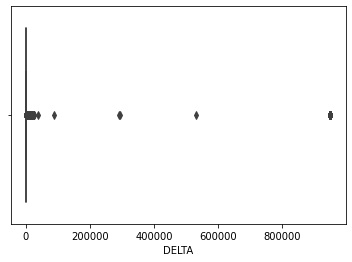

In [ ]:
sns.boxplot(x=df['DELTA'])

In [ ]:
df['DELTA'].describe()

count    2.134946e+07
mean     2.294445e+01
std      1.512642e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      9.560000e+00
max      9.499812e+05
Name: DELTA, dtype: float64

#### 2.4.1 MÉTODO ZSCORE

In [ ]:
from scipy import stats

z_delta = np.abs(stats.zscore(df['DELTA']))
print(z_delta)

[0.01516847 0.01516847 0.01516847 ... 0.01516847 0.01516847 0.00723532]


Según la teoría de puntuaciones z, un valor puede ser considerado atípico cuando toma valores por debajo de -3 o superiores a 3.

In [ ]:
x = np.array(np.where(z_delta>3))
x[0]

array([  285274,   285418,   285514, ..., 21262118, 21263820, 21348621])

In [ ]:
print(len(np.where(z_delta > 3)[0]))

6150


Según este método existirían un total de 6150 outliear, veamos a cuantos contadores afectan.

In [ ]:
rows_outliers = np.array(np.where(z_delta > 3)[0])
rows_outliers

array([  285274,   285418,   285514, ..., 21262118, 21263820, 21348621])

In [ ]:
df_outliers = df.iloc[rows_outliers, :]
df_outliers

,ID,SAMPLETIME,READING,DELTA
283840,33,2019-06-07 02:30:16,8806851.0,4821.0
283938,33,2019-06-13 02:30:06,8897723.0,5380.0
282328,33,2019-06-17 02:29:58,8963594.0,4698.0
282360,33,2019-06-18 02:29:57,8976465.0,4752.0
283505,33,2019-06-20 02:29:53,9007621.0,5366.0
...,...,...,...,...
21280871,2655,2020-01-28 12:00:18,515575.0,6326.0
21280870,2655,2020-01-28 13:00:18,521680.0,6105.0
21313927,2670,2019-11-18 13:00:25,122053.0,4913.0
21315035,2670,2020-01-28 11:00:17,280999.0,4763.0


In [ ]:
df_outliers['ID'].unique()

array([  33,   42,   57,  111,  122,  218,  231,  248,  292,  360,  374,
        375,  418,  474,  545,  635,  770,  812,  873,  907, 1034, 1140,
       1217, 1218, 1247, 1280, 1338, 1339, 1364, 1416, 1431, 1444, 1544,
       1664, 1679, 1727, 1750, 2063, 2068, 2143, 2296, 2459, 2460, 2464,
       2473, 2479, 2481, 2511, 2512, 2571, 2624, 2635, 2655, 2670, 2727])

Se observa que los outliers afectan a un total de 55 contadores.

#### 2.4.2 MÉTODO RANGO INTERCUARTÍLICO

In [ ]:
cols = ['DELTA'] 
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df_outliers2 = df[((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
df_outliers2

,ID,SAMPLETIME,READING,DELTA
5422,0,2019-02-01 08:39:35,331765.00,36.00
170,0,2019-02-01 13:39:34,331835.00,69.00
166,0,2019-02-01 17:39:35,331867.00,27.00
167,0,2019-02-01 19:39:33,331947.00,66.00
171,0,2019-02-02 12:39:32,332050.00,46.00
...,...,...,...,...
21404754,2745,2019-12-06 14:00:00,495402.94,28.53
21404759,2745,2019-12-06 15:00:00,495431.47,28.53
21404749,2745,2019-12-06 16:29:24,495460.00,28.53
21404809,2748,2019-08-03 21:48:03,406848.00,208.00


In [ ]:
df_outliers2['ID'].unique()

array([   0,    1,    2, ..., 2742, 2745, 2748])

Veamos cuales son los outliers comunes a las dos métodos:



In [ ]:
list1 = df_outliers['ID'].unique()
print("Se detectan {n} contadores con outliers por el método de zscore".format(n=len(list1)))

Se detectan 55 contadores con outliers por el método de zscore


In [ ]:
list2 = df_outliers2['ID'].unique()
print("Se detectan {n} contadores con outliers por el método del rango intercuartílico".format(n=len(list2)))

Se detectan 2618 contadores con outliers por el método del rango intercuartílico


In [ ]:
id_outliers = list(set(list1).intersection(list2))
print("Se detectan {n} contadores con outliers por ambos métodos".format(n=len(id_outliers)))

Se detectan 55 contadores con outliers por ambos métodos


En base a los resultados y a fin de no eliminar registros buenos, se decide emplear el método de zscore para la eliminación de outliers. Para ello, se realizará un análisis exhaustivo de los 55 contadores que presentan outliers. 

In [ ]:
list1

array([  33,   42,   57,  111,  122,  218,  231,  248,  292,  360,  374,
        375,  418,  474,  545,  635,  770,  812,  873,  907, 1034, 1140,
       1217, 1218, 1247, 1280, 1338, 1339, 1364, 1416, 1431, 1444, 1544,
       1664, 1679, 1727, 1750, 2063, 2068, 2143, 2296, 2459, 2460, 2464,
       2473, 2479, 2481, 2511, 2512, 2571, 2624, 2635, 2655, 2670, 2727])

#### 2.4.3 ANÁLISIS DE CONTADORES CON OUTLIERS

Dado que no se dispone de una variable categorica que permita distinguir los contadores que corresponden a una vivienda de los que pertenecen a un comercio, no parece adecuado la eliminación de todos los outliers sin realizar un análisis exhaustivo.

Para cada uno de los contadores, se realizan las siguientes exploraciones:

- Extracción de registros con outliers, analizando el número de outliers detectados en relación al número de registros totales. {**DF_33_OUTLIERS = df_outliers[df_outliers['ID']==33]**}

- Análisis descriptivo de la variable 'DELTA'. {**DF_33['DELTA'].describe()**}

- Análisis descriptivo de la variable 'DELTA', sin outliers, a fin de estudiar el comportamiento habitual del contador. {**DF_33_WITHOUT_OUTLIERS['DELTA'].describe()**}

- Estudio temporal de los outliers, a fin de analizar si existen ciertas franjas horarias en las que es más habitual que se produzcan. {**DF_33_OUTLIERS['SAMPLETIME'].apply(lambda x: x.hour).groupby(['HOUR']).size()**}

A continuación, se detallará la información extraida de cada uno de los contadores analizados y las decisiones acatadas, respecto a la eliminación o no de los outliers.

- **CONTADOR 33:** Todos los outlier se producen entorno a las 02:30 de la madrugada. Puesto que se detecta un patrón temporal en el comportamiento de los outliers, se decide no eliminar los outliers de este contador.
- **CONTADOR 42:** Se detecta un único outlier producido a las 15:21. Puesto que se observan registros elevados del contador entorno al mediodía, se mantiene el outlier.
- **CONTADOR 57:** Se observa un único outlier muy alejado del comportamiento habitual del contador, por lo que se decide eliminarlo.
- **CONTADOR 111:** No se detecta ningún patrón en los outliers, tomándose la decisión de suprimirlos.
- **CONTADOR 122:** Los outliers parecen corresponderse con horarios de mañana. Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 218:** 
- **CONTADOR 231:** El contador presenta outliers no muy elevados, todos ellos entorno a las 02:30 de la madrugada. Al detectarse un patrón temporal en el comportamiento de los outliers y no ser muy elevados, se decide mantenerlos.
- **CONTADOR 248:** Los outliers tienen lugar de madrugada y durante la mañana. Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 292:** El contador presenta unicamente 3 outliers, no muy elevados. Además, se observan registros con valores cercanos a los outliers. En base a lo citado, se decide mantener los outliers.
- **CONTADOR 360:** Todos los outliers se registran el mismo día (2019-05-09). Se decide eliminarlos al no tratarse de un comportamiento habitual.
- **CONTADOR 374:** Los outliers se corresponden con registros consecutivos del día 2019-10-26. Se decide eliminarlos al no tratarse de un comportamiento habitual.
- **CONTADOR 375:** No se detecta patrón de comportamiento en los outliers detectados. En base a ello y al tratarse de sólo 3, se decide eliminarlos. 
- **CONTADOR 418:** Los outliers se producen de madrugada (04:00 - 07:00). Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 474:** La mayoría de los outliers se corresponden a registros del día 2019-04-05. Se decide eliminarlos al no tratarse de un comportamiento habitual.
- **CONTADOR 545:** Se observan valores elevados en los registros no nulos del contador. Por tanto, al considerarse los valores elevados un comportamiento habitual, se decide mantener los outliers.
- **CONTADOR 635:** Se detectan dos outlier de valores muy elevados y registrados el mismo día (2019-05-20). Se decide eliminarlos al no tratarse de un comportamiento habitual.
- **CONTADOR 770:** Se observa un único outlier no muy elevado y registros con valores próximos a él. Por ello, se decide mantenerlo.
- **CONTADOR 812:** Se observa que el contador presenta consumos elevados de forma habitual, por lo que se decide mantener los outliers. 
- **CONTADOR 873:** Se detecta un único outlier, muy elevado en comparación con el comportamiento habitual del contador, que se decide eliminar.
- **CONTADOR 907:** Se detecta un único outlier, muy elevado, que se decide eliminar.
- **CONTADOR 1034:** Los outlier se registran en horario de mañana, con mayor concentración en la madrugada. Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 1140:** Se trata de un contador de registros elevados y concentración de outliers entorno a las 12:00 de la mañana. Al detectarse un patrón temporal en el comportamiento de los outliers y un comportamiento habitual en el contador, se decide mantenerlos.
- **CONTADOR 1217:** Se trata de un contador de registros elevados y concentración de outliers en horario de mañana (07:00 - 15:00). Al detectarse un patrón temporal en el comportamiento de los outliers y un comportamiento habitual en el contador, se decide mantenerlos.
- **CONTADOR 1218:** Se detecta un único outlier, de valor muy elevado en comparación con el comportamiento habitual del contador, que se decide eliminar.
- **CONTADOR 1247:** La mayoría de los outliers, a excepción de dos, se producen de madrugada (00:00 - 02:00).  Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 1280:** Todos los outliers se producen en tres días consecutivos. Pese a detectarse un patrón, se observa que todos los outliers presentan el mismo valor excesivo de 'DELTA'. En base a lo detectado, se considera que los outliers se deben a un error y se decide eliminarlos.
- **CONTADOR 1338:** Todos los outliers tienen lugar de madrugada (00:00 - 07:00). Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 1339:** Se trata de un contador con registros elevados de forma habitual, por lo que se decide mantener los outliers.
- **CONTADOR 1364:** Se observa que los outliers tienen lugar en horario comercial (08:00 - 20:00).  Por ello, al considerarse que el contador corresponde a un negocio, se decide mantener los outliers.
- **CONTADOR 1416:** Se trata de un contador con registros elevados de forma habitual y outliers no muy alejados, por lo que se decide mantenerlos.
- **CONTADOR 1431:** Se trata de un contador de valores muy bajos de forma habitual. No obstante, al registrarse todos los outliers en tres días consecutivos, se considera que existe un patrón de comportamiento y, en base a ello, se decide mantener los outliers.
- **CONTADOR 1444:** La mayoría de los outliers se corresponden con una fecha concreta (2019-06-28). Se decide eliminarlos al no tratarse de un comportamiento habitual.
- **CONTADOR 1544:** Se observa que los outliers tienen lugar de madrugada (03:00 - 05:00).  Por ello, al considerarse que el contador corresponde a un negocio, se decide mantener los outliers.
- **CONTADOR 1664:** Se trata de un contador de registros elevados y concentración de outliers de 09:00 a 02:00, lo que podría corresponderse con un comercio de hostelería. Al detectarse un patrón temporal en el comportamiento de los outliers y un comportamiento habitual en el contador, se decide mantenerlos.
- **CONTADOR 1679:** Se detectan dos outliers, no muy elevados, registrados entorno al mediodía (13:00 - 15:00). Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 1727:** Se trata de un contador de registros elevados y concentración de outliers de madrugada (02:00 - 04:00). Al detectarse un patrón temporal en el comportamiento de los outliers y un comportamiento habitual en el contador, se decide mantenerlos.
- **CONTADOR 1750:** 
- **CONTADOR 2063:** El contador presenta un único outlier, de delta excesivo. Al tratarse de un comportamiento alejado de lo habitual, se decide eliminarlo.
- **CONTADOR 2068:** 
- **CONTADOR 2143:** Los outliers se producen de madrugada y en horario de mañana, con mayor concentración a primera hora de la mañana (05:00 - 09:00). Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 2296:** Se observa una mayor concentración de outliers a primera hora de la mañana (06:00 - 10:00). Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 2459:** La mayoría de los outliers se corresponden con registros consecutivos de un mismo día (2019-11-12). Se decide eliminarlos al no tratarse de un comportamiento habitual.
- **CONTADOR 2460:** Los outliers se corresponden con registros consecutivos del día 2019-03-29. Se decide eliminarlos al no tratarse de un comportamiento habitual.
- **CONTADOR 2464:** Los outliers se producen entorno a las 09:30 de la mañana. Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 2473:** Los outliers tienen lugar de madrugada (01:00 - 06:00). Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 2479:** Los outliers se corresponden con registros consecutivos del día 2019-04-10. Se decide eliminarlos al no tratarse de un comportamiento habitual.
- **CONTADOR 2481:** Se observan 100 outliers sin patrón de comportamiento aparente, por lo que se decide suprimirlos.
- **CONTADOR 2511:** Los outliers se corresponden con registros consecutivos del día 2019-02-01. Se decide eliminarlos al no tratarse de un comportamiento habitual.
- **CONTADOR 2512:** La mayoría de los outliers se producen en registros consecutivos de dos días separados (2019-04-12 / 2019-04-17). Se decide eliminarlos al no tratarse de un comportamiento habitual.
- **CONTADOR 2571:** 
- **CONTADOR 2624:** Los outliers detectados se producen entorno al mediodía (13:00 - 15:00). Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 2635:** Un único outlier muy alejado de los valores habituales del contador, por lo que se decide suprimirlo.
- **CONTADOR 2655:** No se detecta patrón de comportamiento en los outliers, motivo por el que se decide eliminarlos.
- **CONTADOR 2670:** Se observan dos outliers, no muy elevados, producidos entorno al mediodía (11:00 - 13:00). Al detectarse un patrón temporal en el comportamiento de los outliers, se decide mantenerlos.
- **CONTADOR 2727:** Se trata de un contador con muy pocos registros, unicamente de dos días, por lo que se decide suprimir, en este caso, el contador completo.

De las decisiones tomadas, respecto a la eliminación o no de outliers, se extraen las siguientes conclusiones:

- Se mantienen los outliers que se concentran en determinadas franjas horarias.
- Se considera que los outliers presentan un patrón de comportamiento temporal cuando se succeden en un mínimo de tres días consecutivos y, en consecuencia, se mantienen.
- Los outliers alejados del comportamiento habitual del contador son suprimidos.

#### 2.4.4 ELIMINACIÓN DE OUTLIERS

Se dispone a eliminar aquellos outliers que parecen corresponderse con errores de medida o comportamiento no habitual.

In [ ]:
df_outliers_delete = df_outliers[(df_outliers['ID']==57) | (df_outliers['ID']==111) | (df_outliers['ID']==360) | (df_outliers['ID']==374) | (df_outliers['ID']==375) | (df_outliers['ID']==474) | (df_outliers['ID']==635) | (df_outliers['ID']==873) | (df_outliers['ID']==907) | (df_outliers['ID']==1218) | (df_outliers['ID']==1280) | (df_outliers['ID']==2063) | (df_outliers['ID']==1444) | (df_outliers['ID']==2068) | (df_outliers['ID']==2459) | (df_outliers['ID']==2460) | (df_outliers['ID']==2479) | (df_outliers['ID']==2481) | (df_outliers['ID']==2511) | (df_outliers['ID']==2512) | (df_outliers['ID']==2635) | (df_outliers['ID']==2655)]
df_outliers_delete

,ID,SAMPLETIME,READING,DELTA
486456,57,2019-12-02 12:29:35,347490.0,289321.0
946710,111,2019-03-17 21:38:51,3335030.0,8750.0
948883,111,2019-04-17 14:37:37,3656030.0,6960.0
948867,111,2019-04-17 15:37:35,3660700.0,4670.0
948358,111,2019-12-10 09:28:43,5859950.0,10460.0
...,...,...,...,...
21280581,2655,2019-11-07 20:00:15,263455.0,5330.0
21279800,2655,2019-12-27 16:00:09,356239.0,4804.0
21280101,2655,2019-12-27 17:00:09,362052.0,5813.0
21280871,2655,2020-01-28 12:00:18,515575.0,6326.0


En base a las decisiones tomadas, se eliminarán un total de 276 registros (número reducido de registros en relación al conjunto de registros del dataset)

In [ ]:
len(df)

21349461

In [ ]:
outliers_index = np.array(df_outliers_delete.index)
df = df.drop(outliers_index)
len(df)

21349185

Además, como ya se ha comentado, se eliminarán los registros del contador 2727, puesto que dispone de muy pocos registros y casi todos ellos nulos. 

In [ ]:
df = df[df['ID']!=2727]
len(df)

21349150

# 3. Enriquecimiento y Análisis descriptivo

## 3.1 Inclusión de nuevas variables

### 3.1.1 Hogar o empresa

Queremos saber si una lectura es de un hogar o de una empresa en virtud del consumo diario

In [ ]:
# Para calcular este punto primero hemos tenido que hacer la agregación diaria para poder catalogar a un registro como
# procedente de una vivienda o de una empresa. Luego hemos creado una máscara de los ids de vivienda para pasársela con un
# condicional a la tabla original, creando de esta forma la columna dummy.

df['DATE'] = df['SAMPLETIME'].dt.date
df_agrupado_piechart=df.groupby(['ID', 'DATE']).agg({'DELTA': [np.sum]})
df_agrupado_piechart.reset_index(inplace=True)
df_agrupado_piechart.columns =['ID', 'DATE', 'DELTA']
df_agrupado_piechart['VIVIENDA'] = np.where(df_agrupado_piechart['DELTA'] < 400, 1, 0) # 0 si no es vivienda (local comercial) y 1 si es vivienda

El consumo medio de una vivienda (con los habitantes de la misma en la media de la Comunidad Valenciana) en un día sería 
                de 132 * 2,42 = 319 litros aproximadamente. Según esto, vamos a categorizar separando las viviendas de los locales comerciales, 
                creando una nueva variable de medición, que también serviría para analizar cómo se distribuyen los valores en cuanto a sus máximos 
                de consumo en el día. Es por ello que se le sumará a ese resultado un margen de error para llegar hasta los 400 litros como máximo.
                
Por lo tanto, si el consumo al día es menor de 400 litros se considerará que es una vivienda, y si es de 400 litros o más, 
                se considerará local comercial.

In [ ]:
df_agrupado_piechart.reset_index(inplace=True)
df_agrupado_piechart_moda = df_agrupado_piechart.groupby('ID')['VIVIENDA'].agg(pd.Series.mode).astype(str).reset_index(drop=True) # Agrupar por la moda de si es vivienda o no para cada fecha
df_agrupado_piechart_moda_df = df_agrupado_piechart_moda.to_frame().reset_index()
df_agrupado_piechart_moda_df.columns = ['ID', 'VIVIENDA']

# Corrección de valores
df_agrupado_piechart_moda_df.loc[df_agrupado_piechart_moda_df['ID'] == 2538, 'VIVIENDA'] = '0'
df_agrupado_piechart_moda_df.loc[df_agrupado_piechart_moda_df['ID'] == 2726, 'VIVIENDA'] = '0'
df_agrupado_piechart_moda_df.loc[df_agrupado_piechart_moda_df['ID'] == 2534, 'VIVIENDA'] = '0'

# FALTA LA EXPLICACIÓN: df_agrupado_piechart_moda_df[(df_agrupado_piechart_moda_df['VIVIENDA']!='0') & (df_agrupado_piechart_moda_df['VIVIENDA']!='1')]


In [ ]:
df_agrupado_piechart_moda_df['VIVIENDA'].value_counts()

1    2430
0     307
Name: VIVIENDA, dtype: int64

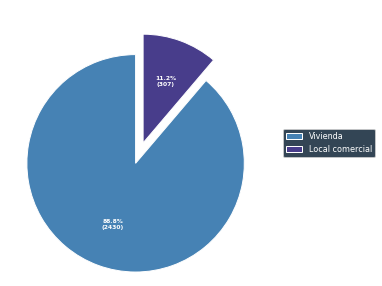

In [ ]:
explode = [0.2, 0.0]

colors = ['steelblue', 'darkslateblue']

wp = {'linewidth' : 1, 'edgecolor' : "white"}

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creación del gráfico
fig, ax = plt.subplots(figsize = (10, 5))
fig.patch.set_alpha(0)
fig.patch.set_facecolor('blue')
wedges, texts, autotexts = ax.pie(df_agrupado_piechart_moda_df['VIVIENDA'].value_counts(),
                                autopct = lambda pct: func(pct, df_agrupado_piechart_moda_df['VIVIENDA'].value_counts()),
                                explode = explode,
                                colors = colors,
                                startangle = 90,
                                wedgeprops = wp,
                                textprops = dict(color ="white"))

                # Añadir leyenda
leyenda = ax.legend(wedges, ['Vivienda', 'Local comercial'],
              loc ="center left",
              bbox_to_anchor =(1, 0, 0.5, 1),
              fontsize = 8,
              facecolor = '#00172B')

for text in leyenda.get_texts():
  plt.setp(text, color = 'white')

plt.setp(autotexts, size = 6, weight = "bold", color = "white")

plt.show()


In [ ]:
df['VIVIENDA']=df_agrupado_piechart_moda_df['VIVIENDA']

### 3.1.2 Dia de la semana

In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df['WEEKDAY'] = df['DATE'].dt.day_name()
df['WEEKDAY_NUMBER'] = df['SAMPLETIME'].dt.dayofweek 
df

,ID,SAMPLETIME,READING,DELTA,DATE,VIVIENDA,WEEKDAY,WEEKDAY_NUMBER
160,0,2019-02-01 00:39:36,331710.0,0.0,2019-02-01,1,Friday,4
152,0,2019-02-01 01:39:36,331710.0,0.0,2019-02-01,1,Friday,4
150,0,2019-02-01 02:39:35,331710.0,0.0,2019-02-01,1,Friday,4
156,0,2019-02-01 03:39:35,331710.0,0.0,2019-02-01,1,Friday,4
161,0,2019-02-01 04:39:35,331710.0,0.0,2019-02-01,1,Friday,4
...,...,...,...,...,...,...,...,...
21404822,2749,2019-10-11 07:27:14,164507.0,2.0,2019-10-11,NaN,Friday,4
21404826,2756,2019-04-06 04:50:17,349758.0,0.0,2019-04-06,NaN,Saturday,5
21404824,2756,2019-04-06 05:50:17,349758.0,0.0,2019-04-06,NaN,Saturday,5
21404827,2756,2019-04-06 06:50:17,349758.0,0.0,2019-04-06,NaN,Saturday,5


### 3.1.3 Mes

In [ ]:
 df['MONTH'] = df['SAMPLETIME'].dt.month_name()
 df['MONTH_NUMBER'] = df['SAMPLETIME'].dt.month # Número del mes para ordenarlo

### 3.1.4 Estación del año

In [ ]:
df['SEASON'] = ' ' # Se crea la variable vacía para rellenarla posteriormente

df.loc[(df['MONTH'] == 'January') | (df['MONTH'] == 'February') | (df['MONTH'] == 'March'), 'SEASON'] = 'Winter'
df.loc[(df['MONTH'] == 'April') | (df['MONTH'] == 'May') | (df['MONTH'] == 'June'), 'SEASON'] = 'Spring'
df.loc[(df['MONTH'] == 'July') | (df['MONTH'] == 'August') | (df['MONTH'] == 'September'), 'SEASON'] = 'Summer'
df.loc[(df['MONTH'] == 'October') | (df['MONTH'] == 'November') | (df['MONTH'] == 'December'), 'SEASON'] = 'Autumn'

# Para ordenar las estaciones en la tabla (por meses)
df.loc[df['SEASON'] == 'Winter', 'SEASON_NUMBER'] = 1
df.loc[df['SEASON'] == 'Spring', 'SEASON_NUMBER'] = 2
df.loc[df['SEASON'] == 'Summer', 'SEASON_NUMBER'] = 3
df.loc[df['SEASON'] == 'Autumn', 'SEASON_NUMBER'] = 4

In [ ]:
df

,ID,SAMPLETIME,READING,DELTA,DATE,VIVIENDA,WEEKDAY,WEEKDAY_NUMBER,MONTH,MONTH_NUMBER,SEASON,SEASON_NUMBER
160,0,2019-02-01 00:39:36,331710.0,0.0,2019-02-01,1,Friday,4,February,2,Winter,1.0
152,0,2019-02-01 01:39:36,331710.0,0.0,2019-02-01,1,Friday,4,February,2,Winter,1.0
150,0,2019-02-01 02:39:35,331710.0,0.0,2019-02-01,1,Friday,4,February,2,Winter,1.0
156,0,2019-02-01 03:39:35,331710.0,0.0,2019-02-01,1,Friday,4,February,2,Winter,1.0
161,0,2019-02-01 04:39:35,331710.0,0.0,2019-02-01,1,Friday,4,February,2,Winter,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21404822,2749,2019-10-11 07:27:14,164507.0,2.0,2019-10-11,NaN,Friday,4,October,10,Autumn,4.0
21404826,2756,2019-04-06 04:50:17,349758.0,0.0,2019-04-06,NaN,Saturday,5,April,4,Spring,2.0
21404824,2756,2019-04-06 05:50:17,349758.0,0.0,2019-04-06,NaN,Saturday,5,April,4,Spring,2.0
21404827,2756,2019-04-06 06:50:17,349758.0,0.0,2019-04-06,NaN,Saturday,5,April,4,Spring,2.0


#### 3.1.5. HORA DEL DÍA

In [ ]:
df['HOUR'] =  df['SAMPLETIME'].dt.hour
df

,ID,SAMPLETIME,READING,DELTA,DATE,VIVIENDA,WEEKDAY,WEEKDAY_NUMBER,MONTH,MONTH_NUMBER,SEASON,SEASON_NUMBER,HOUR
160,0,2019-02-01 00:39:36,331710.0,0.0,2019-02-01,1,Friday,4,February,2,Winter,1.0,0
152,0,2019-02-01 01:39:36,331710.0,0.0,2019-02-01,1,Friday,4,February,2,Winter,1.0,1
150,0,2019-02-01 02:39:35,331710.0,0.0,2019-02-01,1,Friday,4,February,2,Winter,1.0,2
156,0,2019-02-01 03:39:35,331710.0,0.0,2019-02-01,1,Friday,4,February,2,Winter,1.0,3
161,0,2019-02-01 04:39:35,331710.0,0.0,2019-02-01,1,Friday,4,February,2,Winter,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21404822,2749,2019-10-11 07:27:14,164507.0,2.0,2019-10-11,NaN,Friday,4,October,10,Autumn,4.0,7
21404826,2756,2019-04-06 04:50:17,349758.0,0.0,2019-04-06,NaN,Saturday,5,April,4,Spring,2.0,4
21404824,2756,2019-04-06 05:50:17,349758.0,0.0,2019-04-06,NaN,Saturday,5,April,4,Spring,2.0,5
21404827,2756,2019-04-06 06:50:17,349758.0,0.0,2019-04-06,NaN,Saturday,5,April,4,Spring,2.0,6


## 3.2 Representación de relaciones

#### 3.2.1. TIPO DE EDIFICIO

In [ ]:
estudio_vivienda=df.groupby(['VIVIENDA']).agg({'READING': [np.sum], 'DELTA': [np.sum]})
estudio_vivienda.reset_index(inplace=True)
estudio_vivienda.columns =['VIVIENDA', 'READING', 'DELTA']


In [ ]:
estudio_vivienda

,VIVIENDA,READING,DELTA
0,0,118046654.0,3831.0
1,1,923077501.8,30027.2


#### 3.2.2. DÍA DE LA SEMANA

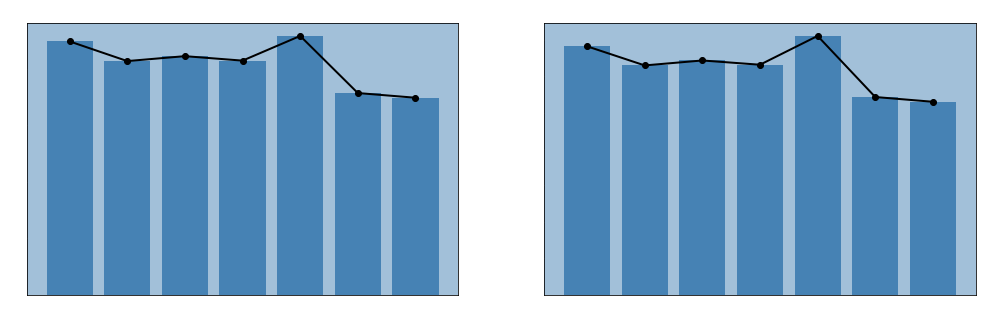

In [ ]:
df_delta_weekday_mean = df.groupby(['WEEKDAY', 'WEEKDAY_NUMBER'])['DELTA'].agg(['mean']).sort_values('WEEKDAY_NUMBER') # Se agrupa por día de la semana y se calcula la media del consumo
df_delta_weekday_mean = df_delta_weekday_mean.reset_index() # Se resetea el índice

# Suma de DELTA por día de la semana
df_delta_weekday_sum = df.groupby(['WEEKDAY', 'WEEKDAY_NUMBER'])['DELTA'].agg(['sum']).sort_values('WEEKDAY_NUMBER')
df_delta_weekday_sum = df_delta_weekday_sum.reset_index()

# Creación de gráfico con la media del consumo por día de la semana y la suma del consumo por día de la semana
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(17, 5))

fig.patch.set_alpha(0)
fig.patch.set_facecolor('blue')

# Bucle para color de máximo y mínimo para el gráfico
# Para la media
col_mean = []
for val in df_delta_weekday_mean['mean']:
    if val < 15.64 or val > 25:
        col_mean.append('darkslateblue')
    else:
        col_mean.append('steelblue')

# Para la suma
col = []
for val in df_delta_weekday_sum['sum']:
    if val < 47289319 or val == 76807087.8200:
        col.append('darkslateblue')
    else:
        col.append('steelblue')

ax0.bar(df_delta_weekday_mean['WEEKDAY'], df_delta_weekday_mean['mean'], color = col_mean)
ax0.plot(df_delta_weekday_mean['WEEKDAY'], df_delta_weekday_mean['mean'], color = 'black', linestyle='solid', linewidth=2, marker = 'o', 
        markerfacecolor = 'black', markersize = 6) # Línea de tendencia
ax0.set_title('Media del consumo por día de la semana', color = 'white')
ax0.set_facecolor('#4682b4')
ax0.patch.set_alpha(0.5)
ax0.tick_params(colors='white', which='both')

ax1.bar(df_delta_weekday_sum['WEEKDAY'], df_delta_weekday_sum['sum'], color = col)
ax1.plot(df_delta_weekday_sum['WEEKDAY'], df_delta_weekday_sum['sum'], color = 'black', linestyle='solid', linewidth=2, marker = 'o', 
        markerfacecolor = 'black', markersize = 6) # Línea de tendencia
ax1.set_title('Suma del consumo por día de la semana', color = 'white')
ax1.set_facecolor('#4682b4')
ax1.patch.set_alpha(0.5)
ax1.tick_params(colors='white', which='both')

plt.show()

En estos gráficos podemos apreciar un aumento del consumo los viernes. La posible explicación que le podemos dar a este fenómeno es que el aumento sea considerable en aquellos contadores pertenecientes a comercios de ocio. 

Por otro lado, el fin de semana presenta un menor consumo de agua. Esto puede verse motivado por el cierre de numerosos locales no destinados al ocio.
A lo largo de la semana laboral exceptuando el viernes, el consumo es bastante sostenido, siendo ligeramente mayor los lunes.

#### 3.2.3. MES DEL AÑO

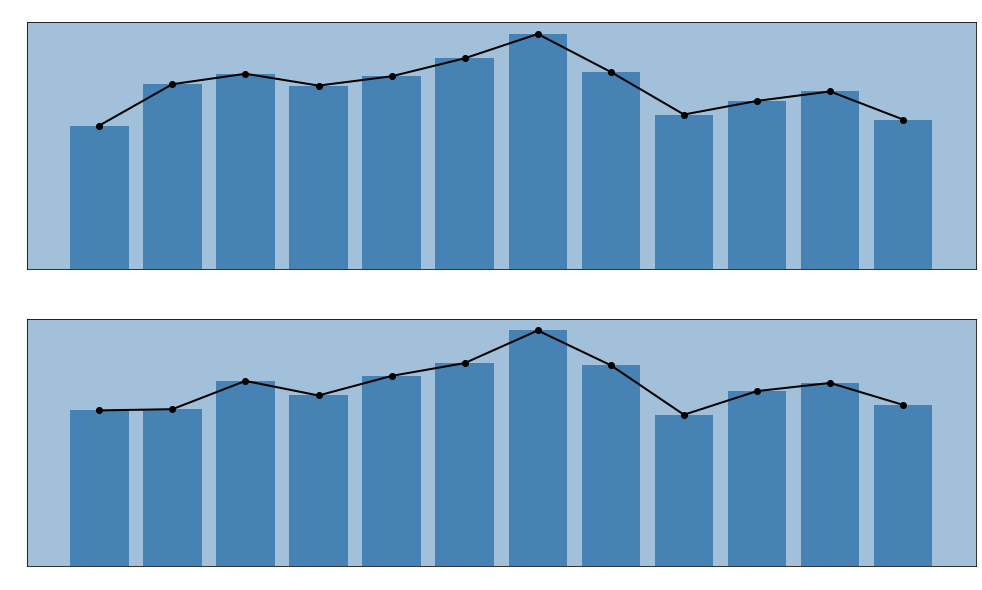

In [ ]:
df_delta_month_mean = df.groupby(['MONTH', 'MONTH_NUMBER'])['DELTA'].agg(['mean']).sort_values('MONTH_NUMBER') # Se agrupa por día de la semana y se calcula la media del consumo
df_delta_month_mean = df_delta_month_mean.reset_index() # Se resetea el índice

# Suma de DELTA por mes
df_delta_month_sum = df.groupby(['MONTH', 'MONTH_NUMBER'])['DELTA'].agg(['sum']).sort_values('MONTH_NUMBER')
df_delta_month_sum = df_delta_month_sum.reset_index()

# Creación de gráfico con la media del consumo por mes y la suma del consumo por mes
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(17, 10))

fig.patch.set_alpha(0)
fig.patch.set_facecolor('blue')

# Bucle para color de máximo y mínimo para el gráfico
# Para la media
col_mean = []
for val in df_delta_month_mean['mean']:
    if val < 15.36 or val > 38.51:
        col_mean.append('darkslateblue')
    else:
        col_mean.append('steelblue')

# Para la suma
col = []
for val in df_delta_month_sum['sum']:
    if val < 27986131 or val > 71641069:
        col.append('darkslateblue')
    else:
        col.append('steelblue')

ax0.bar(df_delta_month_mean['MONTH'], df_delta_month_mean['mean'], color = col_mean)
ax0.plot(df_delta_month_mean['MONTH'], df_delta_month_mean['mean'], color = 'black', linestyle='solid', linewidth=2, marker = 'o', 
        markerfacecolor = 'black', markersize = 6) # Línea de tendencia
ax0.set_title('Media del consumo por mes', color = 'white')
ax0.set_facecolor('#4682b4')
ax0.patch.set_alpha(0.5)
ax0.tick_params(colors='white', which='both')

ax1.bar(df_delta_month_sum['MONTH'], df_delta_month_sum['sum'], color = col)
ax1.plot(df_delta_month_sum['MONTH'], df_delta_month_sum['sum'], color = 'black', linestyle='solid', linewidth=2, marker = 'o', 
        markerfacecolor = 'black', markersize = 6) # Línea de tendencia 
ax1.set_title('Suma del consumo por mes', color = 'white')
ax1.set_facecolor('#4682b4')
ax1.patch.set_alpha(0.5)
ax1.tick_params(colors='white', which='both')

plt.show()


Vemos que a lo largo del año existe una tendencia creciente. Desde enero se incrementa el consumo hasta julio, cuando empiza a decrecer. El pico existente en julio es coherente con que coincida con el mes más caluroso del año.
En octubre y noviembre se experimenta un ligero incremento respecto de septiembre, seguidos de una bajada en diciembre.

La bajada de consumo de agua en los meses no estivales (especialemente) podría parcialmente explicarse por el gran peso del sector turístico en la zona. Muchos de los veraneantes abandonan la comunidad.


#### 3.2.4. HORAS DEL DÍA

In [ ]:
# Agrupar por horas y sumar deltas
estudio_hours = df.groupby('HOUR')['DELTA'].sum()
print(estudio_hours)

HOUR
0     15181046.68
1     14532072.25
2     14869458.43
3     13883407.64
4     13006859.13
5     13663295.94
6     16786886.50
7     19424302.71
8     20992826.95
9     21297712.77
10    22699637.76
11    23306652.10
12    22568896.24
13    21367330.38
14    20436696.09
15    19672006.60
16    18436017.82
17    17011766.55
18    17601707.08
19    18431310.05
20    19216669.57
21    19382199.00
22    17554364.64
23    15413818.62
Name: DELTA, dtype: float64


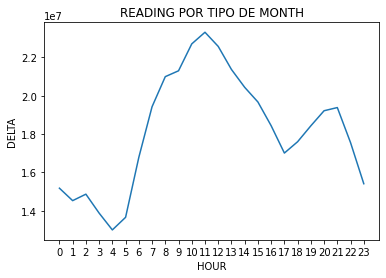

In [ ]:
## Eje X
x = estudio_hours.index

## Eje Y
y = estudio_hours.values

## Grafico
plt.plot(estudio_hours.index, estudio_hours.values)

## Legenda en el eje y
plt.ylabel('DELTA')
 
## Legenda en el eje x
plt.xlabel('HOUR')
plt.xticks(estudio_hours.index)
 
## Título de Gráfica
plt.title('READING POR TIPO DE MONTH')

## Mostrar
plt.show()

Como se puede observar, en términos generales, el consumo de agua es mayor durante la jornada laboral, alcanzando su pico máximo a media mañana. Entorno a este pico, se observa una crecida desde las 05:00 AM, que parece corresponderse con la entrada escalonada de los usuarios a trabajar. De la misma forma, pasadas las 12:00 AM se detecta una caída en el consumo, que parece deberse, de forma análoga, a la salida escalonada de trabajar. De 17:00 a 21:00 se detecta una pequeña crecida, que puede ser causada por la llegada de la población a sus casa y preparación de la cena. 

# 4. Análisis de correlaciones

In [ ]:
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), mask = mask, annot=True, cmap='Dark2');

Vemos lo poco correlacionadas en general que están las variables.
Las únicas correlaciones elevadas que obtenemos no nos aportan ninguna información dado que son READING y DELTA, claramente correladas dado que una es el resultado de la operación matemática de la otra, y por otro lado MONTH_NUMBER y SEASON_NUMBER, también una resultado de la otra.

Por lo demás, el resto de variables no están correlacionadas.

# Exportación del nuevo dataset

---------------------------------------------------

Llegado a este punto, habiendo limpiado nuestro dataset original y habiendo introducido nuevas variables que nos ayudan a entender el comportamiento de consumo de agua, procedemos a exportar la data.
Dado que se nos pide una prediccion por días y por semanas, vamos a agrupar la data que tenemos por dia y a continuación guardarmos el archivo.

Vamos a hacer un group by por dia, convertimos la variable SAMPLETIME a formato datetime (antes era object).

In [ ]:
df_diario = df.groupby(['ID','DATE'], as_index=False)['READING', 'DELTA' ].sum()

In [ ]:
pd.Series(df_diario.isnull().sum()).rename_axis('features/target').to_frame('Missing Value Count')

In [ ]:
print("Number of rows is = ", df_diario.shape[0], " \nNumber of columns is = " , df_diario.shape[1]) 

Así queda la nueva estructura de nuestros datos

In [ ]:
df_diario.head()

Finalmente, los exportamos para poder trabajar la predicción temporal en su Jupyter correspondiente.

Estos datos agrupados por dias nos van a servir para construir el modelo qe posteriormente vamos a correr para cada uno de los ids de contadores.

In [ ]:
df_diario.to_csv(r'/content/drive/MyDrive/Datathon_2022/df_ID_DATE.csv', index = False)